# **Class Activation Map**
Learning Deep Features for Discriminative Localization

https://arxiv.org/pdf/1512.04150.pdf

* https://github.com/nickbiso/Keras-Class-Activation-Map/blob/master/Class%20Activation%20Map(CAM).ipynb

* https://valentinaalto.medium.com/class-activation-maps-in-deep-learning-14101e2ec7e1#:~:text=Class%20Activation%20Maps%20(CAM)%20is,final%20output%20of%20the%20model.
*  https://www.loginradius.com/blog/async/class-activation-mapping/

**1) Import all libraries**

In [49]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
K.clear_session()

2) **Import the pretrained VGG16 model with imagenet weights**

In [50]:
model = VGG16(weights='imagenet')

**3) Load a Sample Image for prediction. Resize the image to fit the input size of VGG**

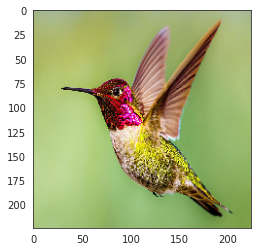

In [51]:
from keras.preprocessing import image
image_path='/content/drive/MyDrive/MY_Learnings/bird.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)

**4)Convert to numpy array**

In [52]:
x = image.img_to_array(img)

**5)Reshape data so that it is in "batch" form because the model only accepts input in this form**

In [53]:
import numpy as np
x = np.expand_dims(x, axis=0)
x.shape

(1, 224, 224, 3)

**6)Preprocessing**

In [54]:
from keras.applications.vgg16 import preprocess_input
x = preprocess_input(x)

**7)Prediction**

In [55]:
import pandas as pd
from keras.applications.vgg16 import decode_predictions
preds = model.predict(x)
predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
print('PREDICTION:',predictions.loc[0,'category'])


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


PREDICTION: hummingbird


**8)Index of the prediction**

In [60]:
argmax = np.argmax(preds[0])


94


**9)Get the index of the prediction**

In [63]:
output = model.output[:, argmax]



(None,)


In [66]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [59]:
#get the final Convolutional Layer
last_conv_layer = model.get_layer('block5_conv3')


In [68]:
# Get the Gradient
grads = K.gradients(output, last_conv_layer.output)[0]

In [72]:
print(grads.shape)

(None, 14, 14, 512)


In [83]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
#Each entry of this tensor is the mean intensity of the gradient over a specific feature map channel. This has a shape of (512,)


(512,)


In [84]:
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

**10)We multiply each channel in the feature map array by "how important this channel is" with regard to the elephant class**

In [85]:
pooled_grads_value, conv_layer_output_value = iterate([x])

In [86]:
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

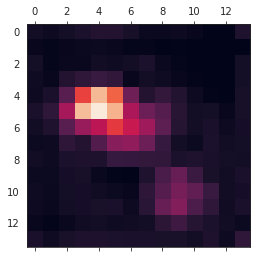

In [87]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [98]:
import cv2
img = cv2.imread(img_path)

In [101]:
#Resize the heatmap
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

In [107]:
#Convert heatmap to RGB
heatmap = np.uint8(255 * heatmap)

In [103]:
#Apply heatmap to original Image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [104]:
#Apply heatmap intensity factor
hif = .8

In [110]:
superimposed_img = heatmap * hif + img


In [111]:
output = 'output.jpeg'
cv2.imwrite(output, superimposed_img)

img=mpimg.imread(output)

Text(0.5, 1.0, 'hummingbird')

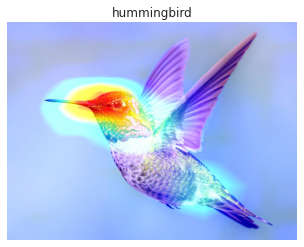

In [112]:
plt.imshow(img)
plt.axis('off')
plt.title(predictions.loc[0,'category'])

## **Put Everything Together**

In [113]:
def cam(img_path,model):
 
    img=mpimg.imread(img_path)
    plt.imshow(img)
    from keras.preprocessing import image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    from keras.applications.vgg16 import preprocess_input
    x = preprocess_input(x)
    preds = model.predict(x)
    predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    import cv2
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    output = 'output.jpeg'
    cv2.imwrite(output, superimposed_img)
    img=mpimg.imread(output)
    plt.imshow(img)
    plt.axis('off')
    plt.title(predictions.loc[0,'category'].upper())
    return None

In [116]:
from keras.applications.vgg16 import VGG16
import matplotlib.image as mpimg
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
K.clear_session()
model = VGG16(weights='imagenet')

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


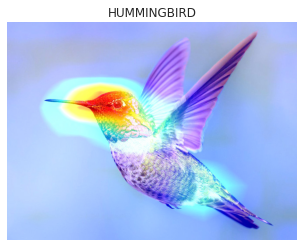

In [117]:
cam('/content/drive/MyDrive/MY_Learnings/bird.jpg',model)

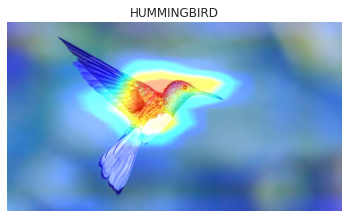

In [127]:
cam('/content/drive/MyDrive/MY_Learnings/birds/bird1.jpg',model)

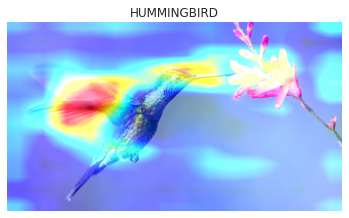

In [128]:
cam('/content/drive/MyDrive/MY_Learnings/birds/bird2.jpg',model)

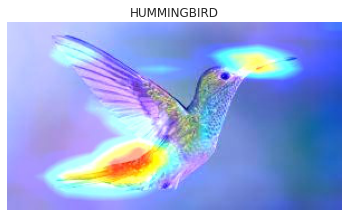

In [129]:
cam('/content/drive/MyDrive/MY_Learnings/birds/bird3.jfif',model)

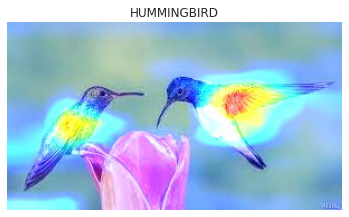

In [130]:
cam('/content/drive/MyDrive/MY_Learnings/birds/bird4.jfif',model)

## **CAT**

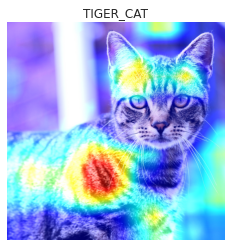

In [121]:
cam('/content/drive/MyDrive/MY_Learnings/cat/cat2.jpg',model)


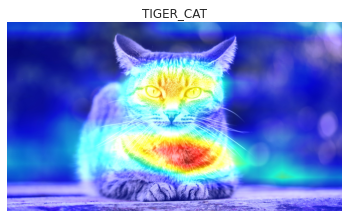

In [122]:
cam('/content/drive/MyDrive/MY_Learnings/cat/cat3.jpg',model)


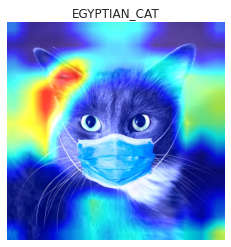

In [123]:
cam('/content/drive/MyDrive/MY_Learnings/cat/cat4.jpg',model)

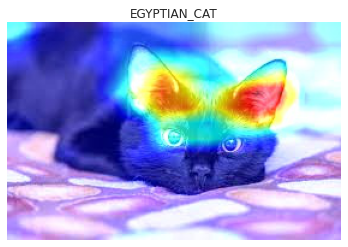

In [124]:
cam('/content/drive/MyDrive/MY_Learnings/cat/cat1.jfif',model)

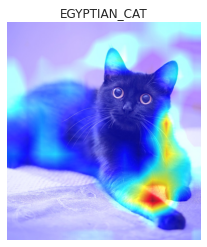

In [125]:
cam('/content/drive/MyDrive/MY_Learnings/cat/cat5.jpg',model)

In [133]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
model = ResNet50(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
102981632/102967424 [==============================] - 1s 0us/step
